# Trend Predicting

* **Problem**: Trend Predicting based on user behaviors
* **Description**: 
  * Create online preference index for each major product group
  * Predict demand trends and draw insights by product group
  * Suggest new service from 1), 2)
* **Dataset**: ? non-numeric column, and ? numeric columns
  * ? : ?
  * Non-numeric columns:
    * 16 non-numeric columns : ?
  * Numeric columns: 
    * 104 numeric columns : ?
 


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os

import datetime
from sklearn.cluster import KMeans


# Load Data

* 'custom.csv'
* 'search1.csv'
* 'search2.csv'
* 'master.csv'
* 'session.csv'
* 'product.csv'


In [4]:
path = Path().resolve().parents[0]
product = pd.read_csv(os.path.join(path, 'Dataset', 'Product.csv'))
search1 = pd.read_csv(os.path.join(path, 'Dataset', 'Search1.csv'))
search2 = pd.read_csv(os.path.join(path, 'Dataset', 'Search2.csv'))
custom = pd.read_csv(os.path.join(path, 'Dataset', 'Custom.csv'))
session = pd.read_csv(os.path.join(path, 'Dataset', 'Session.csv'))
master = pd.read_csv(os.path.join(path, 'Dataset', 'Master.csv'))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Merge Data
1) Merge product purchase data to see features which is expected to affect on purchase of client bought given product group, not individual product

- Merge following csv files
    * Product.csv : CLNT_ID, SESS_ID(Brdige), PD_C(Bridge), PD_BUY_CT, PD_BUY_AM
    * Master.csv : PD_C(Bridge), CLAC1_NM, CLAC2_NM, CLAC3_NM
    * Session.csv : SESS_ID(Bridge), SESS_DT, DVC_CTG_NM, ZON_NM, CITY_NM
    * Custom.csv : CLNT_ID, CLNT_GENDER, CLNT_AGE
    
    
- To get data below
  
  
- Client Information
    * CLNT_ID : Client ID (Primary Key)
    * CLNT_GENDER : Client Gender
    * CLNT_AGE : Client Age
    * DVC_CTG_NM : Client Device
    * ZON_NM : Client Location (briefly)
    * CITY_NM : Client Location (in detail)
    
- Purchase Information
    * SESS_DT : Session Date
    * PD_BUY_CT : Number of product purchased
    * PD_BUY_AM : Price of product purchased
    
- Product Information
    * CLAC1_NM : Product group (largest)
    * CLAC2_NM : Product group (moderate)
    * CLAC3_NM : Product group (smallest)
    
    
    
    
  

In [5]:
merge1 = pd.merge(product, master)
merge1 = merge1.drop(['HITS_SEQ','PD_C', 'PD_ADD_NM', 'PD_BRA_NM', 'PD_NM'], axis=1)
merge2 = pd.merge(merge1, session)
merge2 = merge2.drop(['SESS_ID', 'SESS_SEQ','TOT_PAG_VIEW_CT', 'TOT_SESS_HR_V'], axis=1)
merge3 = pd.merge(merge2, custom)

## Cluster whole clients ignoring clac_nm




In [26]:
def get_cluster_for_all(num_clients, method, test=False, k=0) :
    client_for_clustering = []
    clnt_id = merge3['CLNT_ID'].unique()
          
    # for every client
    for clnt_idx, clnt_num in enumerate(clnt_id) :
        if clnt_idx <= num_clients:
            # in a single client
            client = merge3[merge3['CLNT_ID']==clnt_num].copy()
            client.reset_index(drop=True, inplace=True)
            #print(client)
            
            # attributes to save
            total_price = 0
            total_count = 0
            total_amount = 0
            
            recent = 0
            first_time = 0
            repeat = 0
            lapsed = 0
            
            # variables (not saved)
            latest_purchase = datetime.datetime(2018,1,1)
            lastday = datetime.datetime(2018,9,29)
            
            # loop rows of each client
            for pur_idx in range(client.shape[0]) :
                temp = str(client.iloc[pur_idx, :]['SESS_DT'])
                today = datetime.datetime(int(temp[0:4]), int(temp[4:6]), int(temp[6:8]))
                if (today-latest_purchase).days >= 0 :
                    latest_purchase = today  
                total_price += int(client[['PD_BUY_AM']].iloc[pur_idx, 0].replace(',', '')) * int(str(client[['PD_BUY_CT']].iloc[pur_idx, 0]).replace(',', ''))
                total_count += 1
                total_amount += int(client[['PD_BUY_CT']].iloc[pur_idx, 0])
            
            # attributes to save
            average_price = int(total_price/total_amount)
            average_amount = int(total_amount/total_count)
            if (lastday - latest_purchase).days <= 30 :
                recent = 1
                if total_count == 1 :
                    first_time = 1
            if total_count >= 2 :
                repeat = 1
            if (lastday - latest_purchase).days >= 120 :
                lapsed = 1
                
            new_row = [clnt_num, 
                    total_price,
                    total_count,
                    total_amount,
                    average_price,
                    average_amount,
                    recent,
                    first_time,
                    repeat,
                    lapsed,
                    client['ZON_NM'][0],
                    client['CITY_NM'][0],
                    client['CLNT_GENDER'][0],
                    client['CLNT_AGE'][0]]  
            client_for_clustering.append(new_row)
                
            
        else :
            break;
            
    client_for_clustering = pd.DataFrame(client_for_clustering)
    client_for_clustering.columns = ['CLNT_ID',
                               'TOTAL_PRICE',
                               'TOTAL_COUNT',
                               'TOTAL_AMOUNT',
                               'AVG_PRICE',
                               'AVG_AMOUNT',
                               'RECENT',
                               'FIRST_TIME',
                               'REPEAT',
                               'LAPSED',
                               'ZON_NM',
                               'CITY_NM',
                               'CLNT_GENDER',
                               'CLNT_AGE']
    
    dataset = transform_scale_df(client_for_clustering)

    if method == "kmeans" : 
        if test == False :
            km = KMeans(n_clusters=k)
            km.fit(dataset.iloc[:, 1:])
            labels = pd.DataFrame(km.labels_)
            labels.columns = ['CLUSTER']
            results = pd.concat([dataset,labels], axis=1)
            return results
        elif test == True :
            Sum_of_squared_distances = []
            K = range(1,k)
            for k in K:
                km = KMeans(n_clusters=k)
                km = km.fit(dataset.iloc[:, 1:])
                Sum_of_squared_distances.append(km.inertia_)
            plt.plot(K, Sum_of_squared_distances, 'bx-')
            plt.xlabel('k')
            plt.ylabel('Sum_of_squared_distances')
            plt.title('Elbow Method For Optimal k')
            plt.show()

    

#get_cluster_for_all(10, "kemeans", test=True, k=10)
get_cluster_for_all(30, "kmeans", k=4)   

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.f

CLNT_ID  TOTAL_PRICE  TOTAL_COUNT  TOTAL_AMOUNT  AVG_PRICE  AVG_AMOUNT  \
0   4350334      2309760           56           100   0.000000         0.0   
1   5444959       236820            9             9   0.051303         0.0   
2   5461276       117000            3             3   0.253689         0.0   
3   5482254       799000            9            10   0.906137         0.0   
4   5153670       652200           21            23   0.083893         0.0   
5   5325474        58500            2             2   0.098154         0.0   
6   5325878       288000            6             6   0.397259         0.0   
7   5416905       169000            5             5   0.170737         0.0   
8   5034795        83000            2             2   0.293570         0.0   
9   5090964       262000            5             5   0.467449         0.0   
10  5330255       398000            7             7   0.538549         0.0   
11  5544237       989390           19            19   0.462233         0.0   
12  5724256      4556720          120           121   0.232281         0.0   
13  5773410       173000            3             3   0.551454         0.0   
14  5852180       206000            4             4   0.453092         0.0   
15  4772815       498110           10            10   0.426149         0.0   
16  4142259       450000            8             8   0.528866         0.0   
17  4365910       363100           11            11   0.158119         0.0   
18  4454041       476600           11            11   0.322714         0.0   
19  5724247       149000            4             4   0.225772         0.0   
20  5166994      2162820           43            43   0.433918         0.0   
21  5426815       181000            4             4   0.353391         0.0   
22  5437979       160000            3             3   0.482333         0.0   
23  5593591       492400            8             8   0.613413         0.0   
24  3967070       256800            5             5   0.450859         0.0   
25  6140116      1579100           39            40   0.261298         0.0   
26  5919488       376400            8             8   0.382105         0.0   
27  4123018       321900            4             4   0.915309         0.0   
28  4142055       772060            9             9   1.000000         0.0   
29  5569057       367550            5             5   0.804202         0.0   
30  6193451       550400           10            11   0.429738         0.0   

    RECENT  FIRST_TIME  REPEAT  LAPSED    ZON_NM   CITY_NM  CLNT_GENDER  \
0      1.0         0.0     0.0     0.0  0.000000  0.000000          0.0   
1      0.0         0.0     0.0     0.0  0.142857  0.076923          0.0   
2      0.0         0.0     0.0     1.0  0.285714  0.153846          0.0   
3      0.0         0.0     0.0     0.0  0.000000  0.000000          0.0   
4      0.0         0.0     0.0     0.0  0.000000  0.000000          0.0   
5      0.0         0.0     0.0     0.0  0.142857  0.230769          0.0   
6      0.0         0.0     0.0     0.0  0.428571  0.307692          0.0   
7      0.0         0.0     0.0     0.0  0.000000  0.000000          0.0   
8      0.0         0.0     0.0     1.0  0.571429  0.384615          0.0   
9      0.0         0.0     0.0     0.0  0.000000  0.000000          0.0   
10     0.0         0.0     0.0     0.0  0.142857  0.461538          0.0   
11     0.0         0.0     0.0     0.0  0.142857  0.538462          0.0   
12     0.0         0.0     0.0     0.0  0.000000  0.000000          0.0   
13     0.0         0.0     0.0     1.0  0.000000  0.000000          0.0   
14     1.0         0.0     0.0     0.0  0.142857  0.615385          0.0   
15     1.0         0.0     0.0     0.0  0.142857  0.230769          0.0   
16     0.0         0.0     0.0     0.0  0.714286  0.692308          0.0   
17     0.0         0.0     0.0     0.0  0.000000  0.000000          0.0   
18     0.0         0.0     0.0     0.0  0.428571  0.307692          0.0   
19     

## Copy & Paste code below

In [5]:
def get_attributes(client, clnt_num, clac_nm, client_for_clustering, num_combination) : 

    for clac_idx in range(clac_nm.shape[0]) :

        # attributes to save
        total_price = 0
        total_count = 0
        total_amount = 0
            
        recent = 0
        first_time = 0
        repeat = 0
        lapsed = 0
            
        # variables (not saved)
        latest_purchase = datetime.datetime(2018,1,1)
        lastday = datetime.datetime(2018,9,29)
            
        # loop rows of each client
        for pur_idx in range(client.shape[0]) :
            if num_combination == 3 : 
                purchased = client[['CLAC1_NM', 'CLAC2_NM', 'CLAC3_NM']].iloc[pur_idx, :]
            if num_combination == 2 :
                purchased = client[['CLAC1_NM', 'CLAC2_NM']].iloc[pur_idx, :]
            if num_combination == 1 :
                purchased = client[['CLAC1_NM']].iloc[pur_idx, :]
            unique_cn = clac_nm.iloc[clac_idx, :]
                
            if purchased.equals(unique_cn) :

                temp = str(client.iloc[pur_idx, :]['SESS_DT'])
                today = datetime.datetime(int(temp[0:4]), int(temp[4:6]), int(temp[6:8]))
                if (today-latest_purchase).days >= 0 :
                    latest_purchase = today  
                total_price += int(client[['PD_BUY_AM']].iloc[pur_idx, 0].replace(',', '')) * int(str(client[['PD_BUY_CT']].iloc[pur_idx, 0]).replace(',', ''))
                total_count += 1
                total_amount += int(client[['PD_BUY_CT']].iloc[pur_idx, 0])
            
        # attributes to save
        average_price = int(total_price/total_amount)
        average_amount = int(total_amount/total_count)
        if (lastday - latest_purchase).days <= 30 :
            recent = 1
            if total_count == 1 :
                first_time = 1
        if total_count >= 2 :
            repeat = 1
        if (lastday - latest_purchase).days >= 120 :
            lapsed = 1
        
        if num_combination == 3 :
            new_row = [clnt_num, 
                    unique_cn[0], 
                    unique_cn[1], 
                    unique_cn[2], 
                    total_price,
                    total_count,
                    total_amount,
                    average_price,
                    average_amount,
                    recent,
                    first_time,
                    repeat,
                    lapsed,
                    client['ZON_NM'][0],
                    client['CITY_NM'][0],
                    client['CLNT_GENDER'][0],
                    client['CLNT_AGE'][0]]  
        if num_combination == 2 :
            new_row = [clnt_num, 
                    unique_cn[0], 
                    unique_cn[1], 
                    'NaN', 
                    total_price,
                    total_count,
                    total_amount,
                    average_price,
                    average_amount,
                    recent,
                    first_time,
                    repeat,
                    lapsed,
                    client['ZON_NM'][0],
                    client['CITY_NM'][0],
                    client['CLNT_GENDER'][0],
                    client['CLNT_AGE'][0]]  
        if num_combination == 1 :
            new_row = [clnt_num, 
                    unique_cn[0], 
                    'NaN', 
                    'NaN', 
                    total_price,
                    total_count,
                    total_amount,
                    average_price,
                    average_amount,
                    recent,
                    first_time,
                    repeat,
                    lapsed,
                    client['ZON_NM'][0],
                    client['CITY_NM'][0],
                    client['CLNT_GENDER'][0],
                    client['CLNT_AGE'][0]]  

        client_for_clustering.append(new_row)

In [6]:
def how_many_clients(clacset) : 
    length = 3
    if clacset[2] == 'NaN' :
        length -= 1
    if clacset[1] == 'NaN' :
        length -= 1    

    target = merge3[merge3['CLAC1_NM']==clacset[0]].copy()
    if length >= 2 :
        target = target[target['CLAC2_NM']==clacset[1]].copy()
    if length >= 3 : 
        target = target[target['CLAC3_NM']==clacset[2]].copy()
    
    print(target['CLNT_ID'].unique().shape[0])
    return target['CLNT_ID'].unique().shape[0]

31231


31231

In [7]:
def get_dataset_for_clac(clacset, num_clients) :
    # set numbers of clac_nm
    length = 3
    if clacset[2] == 'NaN' :
        length -= 1
    if clacset[1] == 'NaN' :
        length -= 1
    
    target = merge3[merge3['CLAC1_NM']==clacset[0]].copy()
    if length >= 2 :
        target = target[target['CLAC2_NM']==clacset[1]].copy()
    if length >= 3 : 
        target = target[target['CLAC3_NM']==clacset[2]].copy()
    client_for_clustering = []
    
    clnt_id = target['CLNT_ID'].unique()
    clac1_nm = target['CLAC1_NM'].unique()
    clac2_nm = target['CLAC2_NM'].unique()
    clac3_nm = target['CLAC3_NM'].unique()
          
    # for every client
    for clnt_idx, clnt_num in enumerate(clnt_id) :
        if clnt_idx <= num_clients:
            # in a single client
            client = target[target['CLNT_ID']==clnt_num].copy()
            client.reset_index(drop=True, inplace=True)
        
            # 1) for every combination of clac_nm (CLAC1_NM, CLAC2_NM, CLAC3_NM)
            if length == 3 :
                clac_nm = client[['CLAC1_NM', 'CLAC2_NM', 'CLAC3_NM']].copy().drop_duplicates()
                get_attributes(client, clnt_num, clac_nm, client_for_clustering, 3)
                    
            # 2) for every combination of clac_nm (CLAC1_NM, CLAC2_NM)
            if length == 2 :
                clac_nm = client[['CLAC1_NM', 'CLAC2_NM']].copy().drop_duplicates()
                get_attributes(client, clnt_num, clac_nm, client_for_clustering, 2)
        
            # 3) for every combination of clac_nm (CLAC1_NM)
            if length == 1 : 
                clac_nm = client[['CLAC1_NM']].copy().drop_duplicates()
                get_attributes(client, clnt_num, clac_nm, client_for_clustering, 1)

        else :
            break;
            
    client_for_clustering = pd.DataFrame(client_for_clustering)
    client_for_clustering.columns = ['CLNT_ID',
                               'CLAC1_NM',
                               'CLAC2_NM',
                               'CLAC3_NM',
                               'TOTAL_PRICE',
                               'TOTAL_COUNT',
                               'TOTAL_AMOUNT',
                               'AVG_PRICE',
                               'AVG_AMOUNT',
                               'RECENT',
                               'FIRST_TIME',
                               'REPEAT',
                               'LAPSED',
                               'ZON_NM',
                               'CITY_NM',
                               'CLNT_GENDER',
                               'CLNT_AGE']

    return client_for_clustering

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

def transform_scale_df(df) :
    # cataegory -> numeric, in later version it should be modifed as one-hot vector
    for idx, column in enumerate(df.dtypes) :
        if column == object and idx >= 4:
            df.iloc[:, idx] = pd.factorize(df.iloc[:, idx])[0]
    
    # scale
    for idx, column in enumerate(df.columns) :
        if idx >= 4 :
            df.iloc[:, idx] = scaler.fit_transform(pd.DataFrame(df.iloc[:, idx]))
    
    return df

In [9]:
def get_cluster_for_clac(clacset, num_clients, method, test=False, k=0) :
    dataset = get_dataset_for_clac(clacset, num_clients)
    dataset = transform_scale_df(dataset)
    # code below should be updated when we get different attributes for customer clustering
    
    if method == "kmeans" : 
        if test == False :
            km = KMeans(n_clusters=k)
            km.fit(dataset.iloc[:, 4:])
            labels = pd.DataFrame(km.labels_)
            labels.columns = ['CLUSTER']
            results = pd.concat([dataset,labels], axis=1)
            return results
        elif test == True :
            Sum_of_squared_distances = []
            K = range(1,k)
            for k in K:
                km = KMeans(n_clusters=k)
                km = km.fit(dataset.iloc[:, 4:])
                Sum_of_squared_distances.append(km.inertia_)
            plt.plot(K, Sum_of_squared_distances, 'bx-')
            plt.xlabel('k')
            plt.ylabel('Sum_of_squared_distances')
            plt.title('Elbow Method For Optimal k')
            plt.show()


97149


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.f

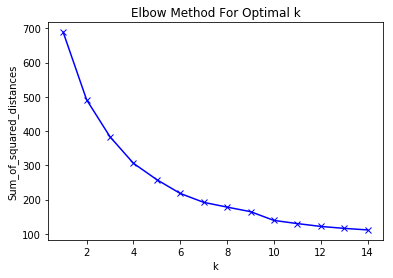

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.f

CLNT_ID  CLAC1_NM CLAC2_NM CLAC3_NM  TOTAL_PRICE  TOTAL_COUNT  \
0  4350334  화장품/뷰티케어     메이크업      NaN     0.148669         0.14   
1  5444959  화장품/뷰티케어     메이크업      NaN     0.008264         0.00   
2  5461276  화장품/뷰티케어     메이크업      NaN     0.026072         0.02   
3  5482254  화장품/뷰티케어     메이크업      NaN     0.055523         0.02   
4  5153670  화장품/뷰티케어     메이크업      NaN     0.008264         0.00   

   TOTAL_AMOUNT  AVG_PRICE  AVG_AMOUNT  RECENT  FIRST_TIME  REPEAT  LAPSED  \
0          0.14   0.378802         0.0     0.0         0.0     1.0     0.0   
1          0.00   0.336406         0.0     0.0         0.0     0.0     0.0   
2          0.02   0.336406         0.0     0.0         0.0     1.0     1.0   
3          0.03   0.543779         0.0     0.0         0.0     1.0     0.0   
4          0.00   0.336406         0.0     0.0         0.0     0.0     1.0   

     ZON_NM   CITY_NM  CLNT_GENDER  CLNT_AGE  CLUSTER  
0  0.000000  0.000000          0.0       0.4        0  
1  0.066667  0.011364          0.0       0.4        5  
2  0.133333  0.022727          0.0       0.4        2  
3  0.000000  0.000000          0.0       0.6        0  
4  0.000000  0.000000          0.0       0.4        4

In [13]:
# 1. 보고싶은 제품군
clacset = ['화장품/뷰티케어', '메이크업', 'NaN'] 
#clacset = ['화장품/뷰티케어', '메이크업', '블러셔/쉐이딩/하이라이터'] 

# 2. 해당 제품군을 구매한 사람이 몇명인지
how_many_clients(clacset)

# 3. 몇명을 불러와서 클러스터링할지 -> 해당 제품군의 소비자중 1000명에 대한 클러스터링 결과가 나옴
num_clients = 1000

# 4. 클러스터의 개수를 몇개로 할지 정하고 싶을때, k : max k
get_cluster_for_clac(clacset, num_clients, 'kmeans', k=15, test=True)

# 5. 클러스터링 된 고객정보, k : # of clusters, output : Pandas DataFrame
get_cluster_for_clac(clacset, num_clients, 'kmeans', k=10).head()

2) 